In [29]:
# python 3.11
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from collections import defaultdict
import math
from sklearn.model_selection import train_test_split

The dataset was loaded, and an initial examination of its first few rows was performed to better understand its structure and contents.

In [30]:
df = pd.read_csv("amazon_reviews.csv")
df.head()

,Title,Content,Star
0,Didn't work,No change in nails at all.,1.0
1,Worst nail product I have ever used.,Garbage! Do not waste your $$$. My nails were ...,1.0
2,Just didn't work,Nails are still brittle,1.0
3,Scum,Didn’t do any improvement at all.,1.0
4,Okay for cuticles,"Helped cuticles, didn't do much for my nails. ...",1.0


A count plot was created to visualize the distribution of star ratings.
After displaying the plot, it was observed that the number of reviews was equal for each star rating.x

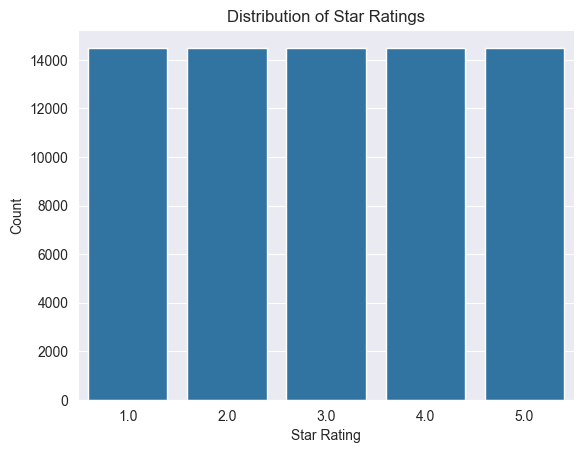

In [31]:
sns.countplot(x='Star', data=df)
plt.title("Distribution of Star Ratings")
plt.xlabel("Star Rating")
plt.ylabel("Count")
plt.show()


The lengths of the titles and contents were calculated by counting the number of words in each.
The average lengths for both titles and contents were then computed to better understand the typical size of the reviews.
Afterward, a histogram was created to visualize the distribution of content lengths.
From the histogram, it was observed that most reviews contained a relatively small number of words, with only a few reviews being significantly longer.

In [32]:
df['title_length'] = df['Title'].astype(str).apply(lambda x: len(x.split()))
df['content_length'] = df['Content'].astype(str).apply(lambda x: len(x.split()))

min_title_length = df['title_length'].min()
max_title_length = df['title_length'].max()

print("Minimum Title Length:", min_title_length)
print("Maximum Content Length:", max_title_length)

print("Average Title Length:", df['title_length'].mean())
print("Average Content Length:", df['content_length'].mean())


Minimum Title Length: 1
Maximum Content Length: 25
Average Title Length: 4.170965517241379
Average Content Length: 36.46804137931034


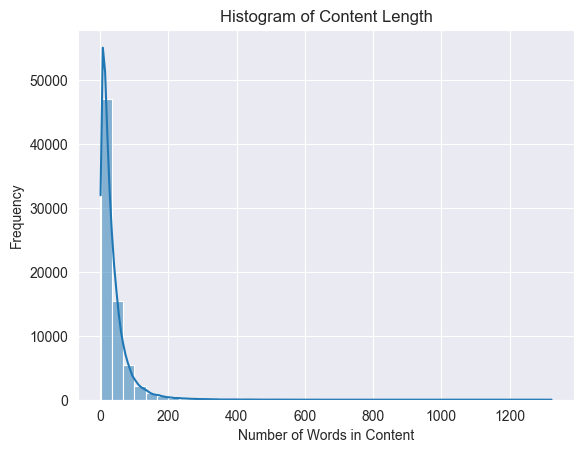

In [33]:
sns.histplot(df['content_length'], bins=40, kde=True)
plt.title("Histogram of Content Length")
plt.xlabel("Number of Words in Content")
plt.ylabel("Frequency")
plt.show()


The text from all reviews was combined into a single string to create a unified body of text.
A word cloud was then generated to visually represent the most frequently used words in the review content.
After displaying the word cloud, it was observed that words such as "use," "one," and "product" appeared most prominently, indicating their frequent usage among the reviews.

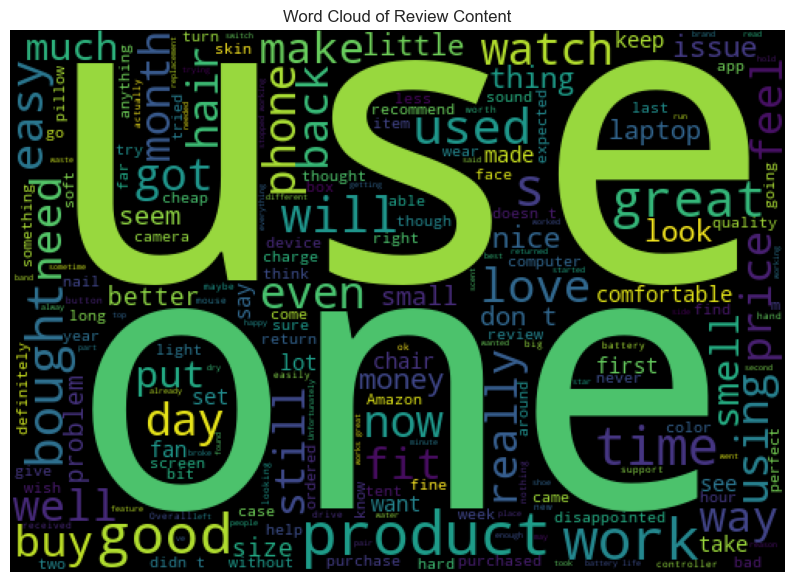

In [34]:
text = " ".join(review for review in df['Content'].astype(str))
wordcloud = WordCloud(width=500, height=350).generate(text)

plt.figure(figsize=(10, 10))
plt.imshow(wordcloud, interpolation='hermite')
plt.axis('off')
plt.title("Word Cloud of Review Content")
plt.show()


The text in the title and content fields was cleaned by converting all characters to lowercase and removing unwanted symbols, while preserving basic punctuation marks for future analysis.
After the cleaning process, the title and content of each review were combined into a single text field to facilitate further processing.

In [35]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z0-9\s.,!?]', '', text)
    return text

df['Title'] = df['Title'].astype(str).apply(clean_text)
df['Content'] = df['Content'].astype(str).apply(clean_text)
df['Combined'] = df['Title'] + " " + df['Content']


A tokenization function was defined to split the text into individual words or into sequences of two or three consecutive words, depending on the specified value of n. A token is a single unit of text, such as a word or phrase, and tokenization is the process of breaking text into these smaller meaningful units. This allowed the text to be prepared for further analysis using unigrams (single words), bigrams (pairs of consecutive words), or trigrams (triplets of consecutive words).

In [36]:
def tokenize(text, n=1):
    words = text.split()
    if n == 1:
        return words
    elif n == 2:
        return [f"{words[i]} {words[i+1]}" for i in range(len(words)-1)]
    elif n == 3:
        return [f"{words[i]} {words[i+1]} {words[i+2]}" for i in range(len(words)-2)]


A sample text from the combined reviews was selected and tokenized into unigrams, bigrams, and trigrams.
Through this process, the structure and behavior of the tokenization function were verified.

In [37]:
sample = df['Combined'].iloc[0]
print("Unigrams:", tokenize(sample, 1))
print("Bigrams:", tokenize(sample, 2))
print("Trigrams:", tokenize(sample, 3))


Unigrams: ['didnt', 'work', 'no', 'change', 'in', 'nails', 'at', 'all.']
Bigrams: ['didnt work', 'work no', 'no change', 'change in', 'in nails', 'nails at', 'at all.']
Trigrams: ['didnt work no', 'work no change', 'no change in', 'change in nails', 'in nails at', 'nails at all.']


A stopword is defined as a commonly occurring word—such as "the," "is," "in," or "and"—that is typically considered to carry limited semantic value in text analysis. These words are often removed during preprocessing so that attention can be focused on more informative terms.

In this context, a predefined list of stopwords was selected (FOUND ON GITHUB https://gist.github.com/sebleier/554280). It included personal pronouns (e.g., "I", "you", "they"), auxiliary verbs (e.g., "is", "was", "have"), articles and conjunctions (e.g., "the", "a", "and", "but"), and prepositions (e.g., "in", "on", "with"). These words were chosen because they are frequently used across various texts but generally do not contribute meaningful information relevant to analytical tasks.

Words like "not" and "nor" were left out of the stopword list on purpose because they express negation, which can strongly change the meaning or tone of a sentence. Keeping them helps keep the true sentiment of the text.

To keep only meaningful words, stopwords were removed from unigrams, bigrams, and trigrams. This helped make the analysis clearer and more useful. Examples were shown before and after to show the effect of removing stopwords.

In [38]:
stopwords = {"i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more", "most", "other", "some", "such", "only", "own", "same", "so", "than", "too", "very", "s", "t", "can", "will", "just", "now"}


def remove_stopwords_unigrams(tokens):
    return [token for token in tokens if token not in stopwords]

df['clean_tokens'] = df['Combined'].apply(lambda x: remove_stopwords_unigrams(tokenize(x, 1)))


def remove_stopwords_from_bigrams(bigrams):
    return [bigram for bigram in bigrams
            if all(word not in stopwords for word in bigram.split())]

df['clean_bigrams'] = df['Combined'].apply(lambda x: remove_stopwords_from_bigrams(tokenize(x, 2)))


def remove_stopwords_from_trigrams(trigrams):
    return [trigram for trigram in trigrams
            if all(word not in stopwords for word in trigram.split())]

df['clean_trigrams'] = df['Combined'].apply(lambda x: remove_stopwords_from_trigrams(tokenize(x, 3)))


A function was implemented to calculate the frequency of tokens within a collection of texts.
Depending on the specified n-gram level, unigrams, bigrams etc.
Stopwords were removed to focus on more meaningful terms, and the frequency of each token was counted and stored.
This process enabled the identification of the most commonly occurring terms or phrases in the dataset. Stopwords will be explained in next code block.

In [39]:
def get_token_frequencies(texts, n_gram):
    freq = defaultdict(int)

    for text in texts:
        if n_gram == 1:
            tokens = remove_stopwords_unigrams(tokenize(text, 1))
        elif n_gram == 2:
            tokens = remove_stopwords_from_bigrams(tokenize(text, 2))
        elif n_gram == 3:
            tokens = remove_stopwords_from_bigrams(tokenize(text, 3))

        for token in tokens:
            freq[token] += 1

    return freq


print("Unigram Before:", tokenize(df['Combined'].iloc[0], 1))
print("Unigram After :", remove_stopwords_unigrams(tokenize(df['Combined'].iloc[0], 1)))


print("Bigram Before:", tokenize(df['Combined'].iloc[0], 2))
print("Bigram After :", remove_stopwords_from_bigrams(tokenize(df['Combined'].iloc[0], 2)))


print("Trigram Before:", tokenize(df['Combined'].iloc[0], 3))
print("Trigram After :", remove_stopwords_from_trigrams(tokenize(df['Combined'].iloc[0], 3)))

Unigram Before: ['didnt', 'work', 'no', 'change', 'in', 'nails', 'at', 'all.']
Unigram After : ['didnt', 'work', 'no', 'change', 'nails', 'all.']
Bigram Before: ['didnt work', 'work no', 'no change', 'change in', 'in nails', 'nails at', 'at all.']
Bigram After : ['didnt work', 'work no', 'no change']
Trigram Before: ['didnt work no', 'work no change', 'no change in', 'change in nails', 'in nails at', 'nails at all.']
Trigram After : ['didnt work no', 'work no change']


A sentiment label was assigned to each review based on its star rating: reviews with 1 or 2 stars were labeled as negative, and those with 4 or 5 stars as positive. Reviews with a 3-star rating were considered neutral and were excluded to maintain a clear separation between sentiment categories. As a result, rows without a sentiment label were removed from the dataset.

To see how 3-star reviews affect results, three strategies were tested: removing them, treating them as positive, and treating them as negative. Then, F1 scores were calculated for unigrams, bigrams, and trigrams under each strategy.

Results:
1. When 3-star reviews were treated as neutral (excluded):
Unigram F1 score: 0.8802

Bigram F1 score: 0.8161

Trigram F1 score: 0.5850

This approach gave the best F1 scores, especially for unigrams and bigrams. Removing 3-star reviews helped the model learn from clearer positive and negative examples, making it easier to tell the difference between the two and improving accuracy.

2. When 3-star reviews were treated as positive:
Unigram F1 score: 0.7732

Bigram F1 score: 0.7199

Trigram F1 score: 0.5673

Treating 3-star reviews as positive resulted in a noticeable drop in F1 scores across all n-gram levels. Since 3-star reviews often contain mixed or neutral language, grouping them with genuinely positive reviews may have introduced noise, reducing the model's ability to learn distinct positive features.

3. When 3-star reviews were treated as negative:
Unigram F1 score: 0.8331

Bigram F1 score: 0.7756

Trigram F1 score: 0.5759

This strategy performed better than labeling 3-star reviews as positive but still worse than excluding them. It suggests that 3-star reviews may be slightly more aligned in language or tone with negative reviews than with positive ones, but they still add ambiguity and lower the model's precision.

Conclusion:

The best classification results were seen when 3-star reviews were left out. This shows that including them—whether labeled as positive or negative—adds confusion and weakens the sentiment signal. So, for binary sentiment analysis focused on clear positive vs. negative separation, it's better to remove neutral reviews from the training data.

In [40]:
def star_label(star):
    if star == 1 or star == 2:
        return 0
    elif star == 4 or star == 5:
        return 1
    else:
        return None

df['Label'] = df['Star'].apply(star_label)
df = df.dropna(subset=['Label'])

The title and content fields were re-concatenated and stored in the combined text column to ensure that the most up-to-date, cleaned versions of both fields were reflected in the analysis.

In [41]:
df.loc[:, 'Combined'] = df['Title'].astype(str) + " " + df['Content'].astype(str)

The dataset was divided into training and testing subsets using an 80-20 split.

In [42]:
train_df, test_df = train_test_split(
    df, test_size=0.2, random_state=42, stratify=df['Label']
)

Token frequencies were calculated from the training dataset using unigrams. A minimum frequency threshold was applied to filter out infrequent tokens. Tokens that appeared at least twice were retained and stored in a set to form the vocabulary of known tokens for further processing.

In [43]:
min_freq = 2
token_freq = get_token_frequencies(train_df['Combined'], n_gram=1)

known_tokens = set(token for token, count in token_freq.items() if count >= min_freq)


Naive Bayes Classification is a probabilistic machine learning method that is used for classification tasks. It is based on Bayes’ Theorem and is built on the assumption that features are conditionally independent given the class label. Probabilities for each class are calculated using training data, and the class with the highest posterior probability is assigned to the input.

A custom NaiveBayesClassifier was developed to perform sentiment classification based on various n-gram representations. The model was designed to support unigram, bigram, trigram, and combined n-gram configurations. During training, tokens were extracted from the input texts, filtered using a list of known tokens (when provided), and their frequencies were updated per class using weighted counts. The weights were adjusted based on the associated star ratings to reflect varying confidence levels in sentiment (e.g., 1-star and 5-star reviews were given higher weights).

During training, each review was tokenized according to the specified n-gram level (1, 2, or 3). Stopwords were removed, and if a list of known tokens was supplied, tokens outside this list were replaced with the placeholder <UNK>. The vocabulary was updated dynamically based on the encountered tokens.

Token counts were stored separately for each sentiment class (positive or negative). In addition to individual token frequencies, the total number of tokens and document counts per class were also recorded. These statistics were used during prediction to compute class-conditional probabilities.

To reflect varying confidence in sentiment labels, reviews were weighted based on their star ratings:

* 1-star and 5-star reviews received a weight of 1.0, as they represent strong sentiment.

* 2-star and 4-star reviews were assigned a lower weight of 0.5, reflecting milder sentiment.

These weights influenced how strongly tokens from each review contributed to the class likelihoods during training.

During prediction, separate token sets were created for the title and content. The probabilities of each class were computed using log-likelihoods, with weighted contributions from the title and content tokens. Laplace smoothing was applied to handle unseen tokens. The class with the highest log-probability was selected as the final prediction.

The classifier was trained separately for unigram, bigram, trigram modes using the training set. Each model was then used to predict the sentiment of reviews in the test set, and the predictions were stored in new columns for evaluation. To control the influence of different text fields, weighted contributions from the title and content were used. The following configurations were tested:

Title Weight 0.7, Content Weight 0.3:

* Unigram F1 Score: 0.88155

* Bigram F1 Score: 0.81512

* Trigram F1 Score: 0.58503

Title Weight 0.6, Content Weight 0.4:

* Unigram F1 Score: 0.88015

* Bigram F1 Score: 0.81612

* Trigram F1 Score: 0.58503

Title Weight 0.5, Content Weight 0.5:

* Unigram F1 Score: 0.87644

* Bigram F1 Score: 0.81442

* Trigram F1 Score: 0.58462

Title Weight 0.4, Content Weight 0.6:

* Unigram F1 Score: 0.87059

* Bigram F1 Score: 0.80928

* Trigram F1 Score: 0.58430

The results indicate that while title-dominant weights generally produced better performance, the best overall balance across unigram and bigram models was achieved at a title weight of 0.6 and content weight of 0.4.

This setup was chosen because it gave the best bigram F1 score (0.8161) and one of the top unigram scores (0.8802). Giving slightly more weight to the title helped the model use the strong sentiment in summaries while still using content for context, leading to better predictions.

Results:

Unigram Classifier

* The unigram model consistently achieved the highest F1 scores across different experiments. This suggests that individual word presence provides strong discriminative signals for sentiment when appropriately weighted and smoothed. The simplicity and low sparsity of unigrams likely contributed to this performance.

Bigram Classifier

* The bigram model performed slightly worse than the unigram model, though still competitively. The increased vocabulary size and reduced overlap between reviews may have limited their generalizability.

Trigram Classifier

* The trigram model had the lowest F1 scores in all cases. Since trigrams are very specific and rare, they don’t appear often, even in similar reviews. This made the model's predictions less reliable and harder to apply to new data.


In [44]:
class NaiveBayesClassifier:
    def __init__(self, n_gram=1):
        self.n_gram = n_gram
        self.class_token_counts = defaultdict(lambda: defaultdict(int))
        self.class_total_tokens = defaultdict(int)
        self.class_doc_counts = defaultdict(int)
        self.vocabulary = set()
        self.num_docs = 0
        self.known_tokens = None

    def train(self, texts, labels, stars):
        for text, label, star in zip(texts, labels, stars):
            self.class_doc_counts[label] += 1
            self.num_docs += 1

            weight = 1.0
            if label == 0:
                weight = 1.0 if star == 1 else 0.5
            elif label == 1:
                weight = 1.0 if star == 5 else 0.5

            if self.n_gram == 1:
                tokens = remove_stopwords_unigrams(tokenize(text, 1))
            elif self.n_gram == 2:
                tokens = remove_stopwords_from_bigrams(tokenize(text, 2))
            elif self.n_gram == 3:
                tokens = remove_stopwords_from_trigrams(tokenize(text, 3))


            for token in tokens:
                if self.known_tokens is not None:
                    token = token if token in self.known_tokens else "<UNK>"
                self.vocabulary.add(token)
                self.class_token_counts[label][token] += weight
                self.class_total_tokens[label] += weight

    def predict(self, title, content):


        if self.n_gram == 1:
            title_tokens = remove_stopwords_unigrams(tokenize(title, 1))
            content_tokens = remove_stopwords_unigrams(tokenize(content, 1))
        elif self.n_gram == 2:
            title_tokens = remove_stopwords_from_bigrams(tokenize(title, 2))
            content_tokens = remove_stopwords_from_bigrams(tokenize(content, 2))
        elif self.n_gram == 3:
            title_tokens = remove_stopwords_from_trigrams(tokenize(title, 3))
            content_tokens = remove_stopwords_from_trigrams(tokenize(content, 3))


        class_scores = {}
        vocab_size = len(self.vocabulary)

        for c in self.class_doc_counts:
            log_prior = math.log(self.class_doc_counts[c] / self.num_docs)
            total_tokens = self.class_total_tokens[c]
            title_weight = 0.7
            content_weight = 0.3

            def log_sum(tokens, weight):
                return sum(
                    weight * math.log(
                        (self.class_token_counts[c].get(token if token in self.vocabulary else "<UNK>", 0) + 1)
                        / (total_tokens + vocab_size)
                    )
                    for token in tokens
                )

            log_prob = log_prior + log_sum(title_tokens, title_weight) + log_sum(content_tokens, content_weight)
            class_scores[c] = log_prob


        return max(class_scores, key=class_scores.get)



nb_unigram = NaiveBayesClassifier(n_gram=1)
nb_bigram = NaiveBayesClassifier(n_gram=2)
nb_trigram = NaiveBayesClassifier(n_gram=3)

nb_unigram.train(train_df['Combined'], train_df['Label'], train_df['Star'])
nb_bigram.train(train_df['Combined'], train_df['Label'], train_df['Star'])
nb_trigram.train(train_df['Combined'], train_df['Label'], train_df['Star'])


test_df['pred_uni'] = test_df.apply(lambda row: nb_unigram.predict(row['Title'], row['Content']), axis=1)
test_df['pred_bi'] = test_df.apply(lambda row: nb_bigram.predict(row['Title'], row['Content']), axis=1)
test_df['pred_tri'] = test_df.apply(lambda row: nb_trigram.predict(row['Title'], row['Content']), axis=1)

Predictions generated by each Naive Bayes model were evaluated using a custom metrics function. For each prediction, true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN) were counted. Based on these counts, the following metrics were computed:

* Accuracy: The ratio of correctly predicted instances over all predictions.

* Precision: The ratio of correctly predicted positive instances over all predicted positives.

* Recall: The ratio of correctly predicted positive instances over all actual positives.

* F1-score: The harmonic mean of precision and recall.

Metrics were calculated for each model individually and then assembled into a comparison table. This table was formatted to display the key performance indicators for each model in a concise and interpretable format.

In [45]:
def metrics(y_true, y_pred):
    TP = FP = TN = FN = 0

    for true, pred in zip(y_true, y_pred):
        if true == 1 and pred == 1:
            TP += 1
        elif true == 0 and pred == 1:
            FP += 1
        elif true == 0 and pred == 0:
            TN += 1
        elif true == 1 and pred == 0:
            FN += 1

    accuracy = (TP + TN) / (TP + TN + FP + FN) if TP + TN + FP + FN > 0 else 0
    precision = TP / (TP + FP) if TP + FP > 0 else 0
    recall = TP / (TP + FN) if TP + FN > 0 else 0
    f1 = 2 / (1/precision + 1/recall) if precision + recall > 0 else 0

    return {
        "TP": TP, "TN": TN, "FP": FP, "FN": FN,
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }


metrics_uni = metrics(test_df['Label'].tolist(), test_df['pred_uni'].tolist())
metrics_bi = metrics(test_df['Label'].tolist(), test_df['pred_bi'].tolist())
metrics_tri = metrics(test_df['Label'].tolist(), test_df['pred_tri'].tolist())

results_df = pd.DataFrame([
    {"Model": "Unigram", **metrics_uni},
    {"Model": "Bigram", **metrics_bi},
    {"Model": "Trigram", **metrics_tri}
])

results_df = results_df[["Model", "accuracy", "precision", "recall", "f1_score"]]
results_df

,Model,accuracy,precision,recall,f1_score
0,Unigram,0.880862,0.876449,0.886724,0.881556
1,Bigram,0.815776,0.818024,0.812241,0.815122
2,Trigram,0.544828,0.537551,0.641724,0.585036


The predictions generated by each Naive Bayes model were assessed using a custom metrics function. This function was used to calculate key performance metrics based on the counts of true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN). The following metrics were then derived:

* Accuracy: The proportion of correctly predicted instances out of all predictions.

* Precision: The ratio of correctly predicted positive instances to the total predicted positives.

* Recall: The ratio of correctly predicted positive instances to the total actual positives.

F1-score: The harmonic mean of precision and recall, providing a balance between the two metrics.

The metrics were computed individually for each Naive Bayes model (unigram, bigram, trigram, and combined) and were organized into a comparison table. This table was structured to present each model's key performance indicators in a clear and easy-to-understand format. The comparison of the models allowed for an evaluation of their relative strengths and weaknesses in terms of prediction accuracy and reliability.

In [46]:
def confusion_matrix(y_true, y_pred):
    TP = FP = TN = FN = 0

    for true, pred in zip(y_true, y_pred):
        if true == 1 and pred == 1:
            TP += 1
        elif true == 0 and pred == 1:
            FP += 1
        elif true == 0 and pred == 0:
            TN += 1
        elif true == 1 and pred == 0:
            FN += 1

    return [[TN, FP],
            [FN, TP]]


cm_uni = confusion_matrix(test_df['Label'].tolist(), test_df['pred_uni'].tolist())
print(" Unigram Confusion Matrix:")
print("[TN FP]")
print(cm_uni[0])
print("[FN TP]")
print(cm_uni[1])

cm_bi = confusion_matrix(test_df['Label'].tolist(), test_df['pred_bi'].tolist())
print("\n Bigram Confusion Matrix:")
print("[TN FP]")
print(cm_bi[0])
print("[FN TP]")
print(cm_bi[1])

cm_tri = confusion_matrix(test_df['Label'].tolist(), test_df['pred_tri'].tolist())
print("\n Trigram Confusion Matrix:")
print("[TN FP]")
print(cm_tri[0])
print("[FN TP]")
print(cm_tri[1])

 Unigram Confusion Matrix:
[TN FP]
[5075, 725]
[FN TP]
[657, 5143]

 Bigram Confusion Matrix:
[TN FP]
[4752, 1048]
[FN TP]
[1089, 4711]

 Trigram Confusion Matrix:
[TN FP]
[2598, 3202]
[FN TP]
[2078, 3722]


Final Summary and Conclusion:
To evaluate the effectiveness of different Naive Bayes models for sentiment classification, a comprehensive performance assessment was conducted using a custom metrics function. This function calculated key classification metrics—accuracy, precision, recall, and F1-score—based on the confusion matrix components: true positives (TP), false positives (FP), true negatives (TN), and false negatives (FN). The models assessed included unigram, bigram, trigram, and a combined n-gram approach, and their results were presented in a structured comparison table for clarity.
The analysis revealed several important insights:
1. Unigram Models Showed Strong Overall Performance :
The unigram model consistently outperformed the others in terms of F1-score and accuracy, especially when neutral (3-star) reviews were excluded. This indicates that single-word features captured most of the sentiment-related patterns effectively and provided a strong signal for classification. Its simplicity and performance make it a reliable baseline for sentiment analysis tasks.
2. Bigram and Trigram Models Introduced More Noise :
While bigrams and trigrams provided slightly more contextual information, their performance was generally lower. This is likely due to the increased sparsity and dimensionality of the feature space, which may have introduced noise and reduced generalizability—especially for trigrams. These models are more sensitive to data size and may benefit from larger datasets or smoothing techniques.
3. Impact of Labeling 3-Star Reviews :
The way 3-star reviews were handled had a significant effect on model performance:

* When excluded as neutral, the models performed best, likely due to reduced ambiguity in the training data.

* When labeled as positive, performance dropped considerably, suggesting that 3-star reviews do not strongly align with positive sentiment.

* When labeled as negative, the results were better than the positive case, implying that 3-star reviews might contain more language associated with dissatisfaction or mixed emotions.
4. F1-Score as a Balanced Indicator :
While accuracy gives a general overview of correctness, F1-score proved more insightful in evaluating the models, especially given any class imbalance. Since F1-score considers both precision and recall, it provided a more nuanced view of a model’s ability to correctly identify sentiment without being biased by dominant classes.


Conclusion:
The results showed that the unigram-based Naive Bayes model performed the best, especially when neutral (3-star) reviews were removed to reduce ambiguity. Adding bigrams and trigrams did not improve performance and sometimes made results worse due to added complexity. How neutral reviews are labeled also had a big impact—treating them as positive lowered the accuracy the most. Overall, this highlights the importance of clean data, simple features, and careful labeling in building effective sentiment analysis models.
